## Analysis of the optuna search results

Import necessary libraries

In [ ]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn.utils import resample
from xgboost import XGBRegressor

sys.path.append("/home/mn628/FEDERATED_LEARNING/mn628/")

from src.plot_notebooks import *

Dataframe containing combination of features and their corresponding results (obtained after 14 tested configurations):

In [ ]:
df_features = pd.DataFrame(
    {
        "F1 Score": [
            0.476,
            0.429,
            0.147,
            0.402,
            0.371,
            0.398,
            0.438,
            0.51,
            0.424,
            0.398,
            0.317,
            0.438,
            0.467,
            0.294,
        ],
        "Batch Size": [64, 64, 64, 16, 16, 128, 128, 32, 16, 32, 32, 32, 128, 64],
        "Number of Filters": [24, 16, 32, 16, 16, 24, 8, 8, 48, 64, 48, 24, 64, 64],
        "Dropout Rate": [
            0.361,
            0.454,
            0.232,
            0.327,
            0.488,
            0.377,
            0.437,
            0.31,
            0.41,
            0.201,
            0.243,
            0.284,
            0.305,
            0.378,
        ],
        "Learning Rate": [
            0.0056,
            0.0042,
            0.043,
            0.0006,
            0.0052,
            0.00008,
            0.0013,
            0.00985,
            0.0014,
            0.034,
            0.00001,
            0.01,
            0.013,
            0.075,
        ],
        "Number of Layers": [2, 3, 2, 3, 3, 4, 4, 3, 3, 2, 4, 2, 2, 4],
    }
)

In [7]:
df_features.sort_values(by="F1 Score", ascending=False, inplace=True)
df_features

,F1 Score,Batch Size,Number of Filters,Dropout Rate,Learning Rate,Number of Layers
7,0.510,32,8,0.310,0.00985,3
0,0.476,64,24,0.361,0.00560,2
12,0.467,128,64,0.305,0.01300,2
6,0.438,128,8,0.437,0.00130,4
11,0.438,32,24,0.284,0.01000,2
1,0.429,64,16,0.454,0.00420,3
8,0.424,16,48,0.410,0.00140,3
3,0.402,16,16,0.327,0.00060,3
5,0.398,128,24,0.377,0.00008,4
9,0.398,32,64,0.201,0.03400,2


In [8]:
X = df_features.drop(columns="F1 Score")  # Model parameters
y = df_features["F1 Score"]  # Target variable (f1 score)

Bootstrapping for getting the SHAP values

In [9]:
bootstrap_shap_vals = []
n_bootstrap = 1000

for _ in range(n_bootstrap):
    X_boot, y_boot = resample(X, y)
    model = XGBRegressor().fit(X_boot, y_boot)
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    bootstrap_shap_vals.append(mean_abs_shap)

# Aggregate SHAP stats
bootstrap_shap_vals = np.array(bootstrap_shap_vals)
shap_means = bootstrap_shap_vals.mean(axis=0)
shap_stds = bootstrap_shap_vals.std(axis=0)

In [10]:
# Create dataframe for plotting
shap_df = pd.DataFrame(
    {"Hyperparameter": X.columns, "Mean |SHAP|": shap_means, "Std": shap_stds}
).sort_values(by="Mean |SHAP|", ascending=False)

print(shap_df)

      Hyperparameter  Mean |SHAP|       Std
3      Learning Rate     0.036974  0.024409
2       Dropout Rate     0.019072  0.022671
1  Number of Filters     0.014175  0.014611
0         Batch Size     0.008969  0.007960
4   Number of Layers     0.004811  0.011970


In [11]:
nl_importance = (
    df_features.groupby("Number of Layers")["F1 Score"]
    .mean()
    .sort_values(ascending=False)
)
nl_importance = pd.DataFrame(nl_importance)
nl_importance["Number of repeats"] = (
    df_features["Number of Layers"].value_counts().sort_index()
)
nl_importance

,F1 Score,Number of repeats
Number of Layers,,
3,0.42720,5
2,0.38520,5
4,0.36175,4


In [12]:
bs_importance = (
    df_features.groupby("Batch Size")["F1 Score"].mean().sort_values(ascending=False)
)
bs_importance = pd.DataFrame(bs_importance)
bs_importance["Number of repeats"] = (
    df_features["Batch Size"].value_counts().sort_index()
)
bs_importance

,F1 Score,Number of repeats
Batch Size,,
128,0.434333,3
32,0.415750,4
16,0.399000,3
64,0.336500,4


In [13]:
nf_importance = (
    df_features.groupby("Number of Filters")["F1 Score"]
    .mean()
    .sort_values(ascending=False)
)
nf_importance = pd.DataFrame(nf_importance)
nf_importance["Number of repeats"] = (
    df_features["Number of Filters"].value_counts().sort_index()
)
nf_importance

,F1 Score,Number of repeats
Number of Filters,,
8,0.474000,2
24,0.437333,3
16,0.400667,3
64,0.386333,3
48,0.370500,2
32,0.147000,1


In [14]:
low_params = shap_df.tail(3)
top_params = shap_df.head(2)

print(top_params)
print("-------------------------------------------")
print(low_params)

  Hyperparameter  Mean |SHAP|       Std
3  Learning Rate     0.036974  0.024409
2   Dropout Rate     0.019072  0.022671
-------------------------------------------
      Hyperparameter  Mean |SHAP|       Std
1  Number of Filters     0.014175  0.014611
0         Batch Size     0.008969  0.007960
4   Number of Layers     0.004811  0.011970


In [15]:
grouped_data = {}
for param in low_params["Hyperparameter"].values:
    # Calculate mean f1 for each value of the parameter
    grouped = df_features.groupby(param)["F1 Score"].mean().sort_values(ascending=False)

    # Count how many times each value appears
    counts = df_features[param].value_counts().sort_index()

    # Create dataframe with both mean f1 and count
    df = grouped.to_frame("mean_f1")
    df["count"] = counts.loc[df.index].values

    # Store in dictionary
    grouped_data[param] = df

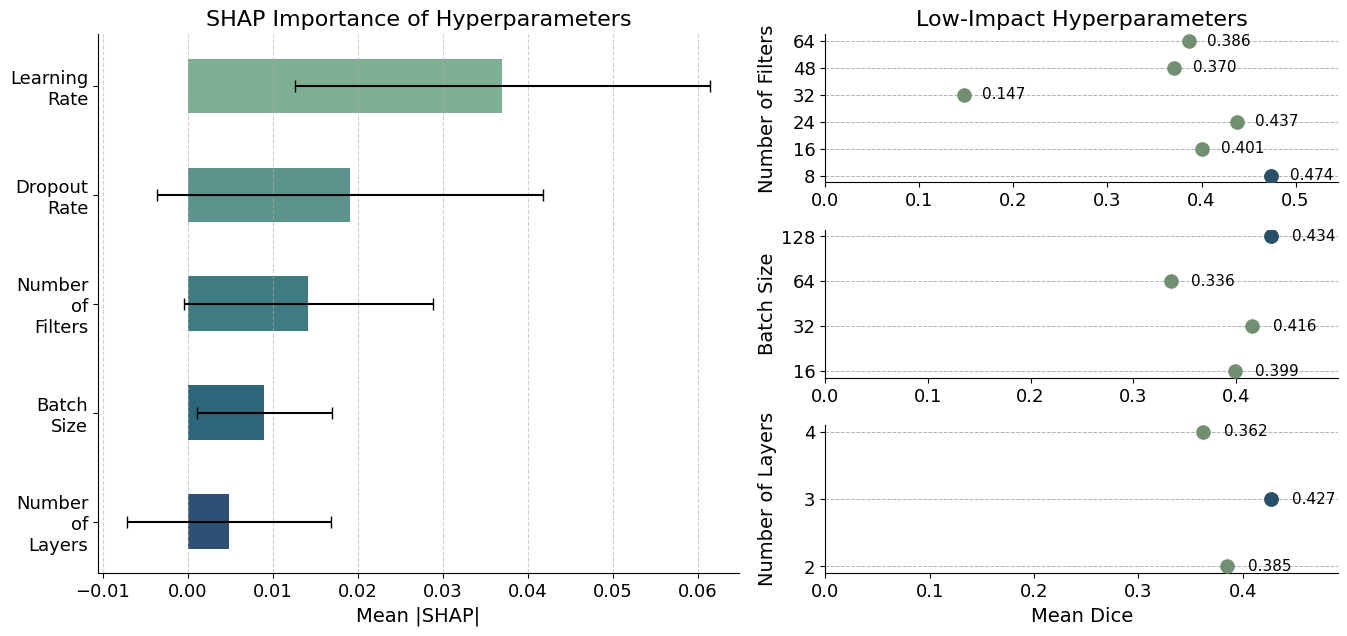

In [20]:
SHAP_analysis(shap_df, low_params, grouped_data)

- The learning rate had the highest influence, with a mean SHAP value of 0.037, followed by dropout with a mean SHAP value of 0.019.
- These two parameters were selected for further tuning while the remaining ones (number of layers, base number of filters, and batch size) were fixed to the values that yielded the highest mean Dice scores, highlighted on the right-hand side of the figure above.
- After evaluating an additional 14 configurations, the final U-Net architecture was found to perform best with a learning rate of 0.001, a dropout rate of 0.3, three convolutional layers, a base of eight filters, and a batch size of 128 , all contributing to faster and more stable training.